In [2]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

import plotting

## Loading data

In [4]:
data_dir = Path("../data/paper_data")
figures_dir = data_dir / "figures"
figures_dir.mkdir(exist_ok=True)

In [5]:
annotated_df = pd.read_csv(data_dir / "annotations.csv")
annotated_df["release_date"] = pd.to_datetime(annotated_df["release_date"])

In [6]:
all_similarity_scores = pd.read_parquet(data_dir / "all_similarity_scores.parquet")

In [7]:
bust_dfs = {}
for m in plotting.METHODS:
    filename = data_dir / "posebusters_results" / f"{m}.csv"
    if filename.exists():
        bust_dfs[m] = pd.read_csv(filename)

In [8]:
full_datasets = {}
for method in plotting.METHODS:
    filename = data_dir / "predictions" / f"{method}.csv"
    df = pd.read_csv(filename, low_memory=False)
    keep_columns = [
        "target",
        "ligand_instance_chain",
        "lddt_pli",
        "rmsd",
        "lddt_lp",
        "bb_rmsd",
        "seed",
        "sample",
        "ranking_score",
        "ligand_is_proper",
        "prot_lig_chain_iptm_average_lddt_pli",
        "prot_lig_chain_iptm_min_lddt_pli",
        "prot_lig_chain_iptm_max_lddt_pli",
        "lig_prot_chain_iptm_average_lddt_pli",
        "lig_prot_chain_iptm_min_lddt_pli",
        "lig_prot_chain_iptm_max_lddt_pli",
        "prot_lig_chain_iptm_average_rmsd",
        "prot_lig_chain_iptm_min_rmsd",
        "prot_lig_chain_iptm_max_rmsd",
        "lig_prot_chain_iptm_average_rmsd",
        "lig_prot_chain_iptm_min_rmsd",
        "lig_prot_chain_iptm_max_rmsd",
        "model_ligand_chain_lddt_pli",
        "model_ligand_chain_rmsd",
        "ligand_ccd_code",
        "model_ligand_smiles",
        "pred_pocket_f1",
    ]
    if "seed" not in df.columns:
        df["seed"] = 1
    if "sample" not in df.columns:
        df["sample"] = 1
    if "ranking_score" not in df.columns:
        df["ranking_score"] = 1
    if "lig_prot_chain_iptm_average_rmsd" not in df.columns:
        df["lig_prot_chain_iptm_average_rmsd"] = 1
    if "prot_lig_chain_iptm_average_rmsd" not in df.columns:
        df["prot_lig_chain_iptm_average_rmsd"] = 1
    if "pred_pocket_f1" not in df.columns:
        df["pred_pocket_f1"] = 1
    keep_columns = [c for c in keep_columns if c in df.columns]
    full_datasets[method] = (
        df[keep_columns].rename(columns={"target": "system_id"}).reset_index(drop=True)
    )
    full_datasets[method]["group_key"] = (
        full_datasets[method]["system_id"]
        + "__"
        + full_datasets[method]["ligand_instance_chain"]
    )
    full_datasets[method]["method"] = method
    full_datasets[method] = (
        full_datasets[method]
        .sort_values(by=["lddt_pli", "rmsd"], ascending=[False, True])
        .groupby(["group_key", "seed", "sample"])
        .head(1)
        .reset_index(drop=True)
    )
    if method in bust_dfs:
        full_datasets[method] = full_datasets[method].merge(
            bust_dfs[method][["system_id", "ligand_instance_chain", "pb_success"]],
            on=["system_id", "ligand_instance_chain"],
            how="left",
        )
        full_datasets[method]["pb_success"] = (
            full_datasets[method]["pb_success"].fillna(False).astype(float)
        )
    else:
        full_datasets[method]["pb_success"] = -1

In [9]:
def pivot_df(df, annotated_df):
    df = df.pivot(
        index=[
            "group_key",
            "system_id",
            "ligand_is_proper",
            "ligand_instance_chain",
        ],
        columns="method",
        values=[
            "lddt_pli",
            "rmsd",
            "lddt_lp",
            "bb_rmsd",
            "pb_success",
            "pred_pocket_f1",
        ],
    ).reset_index()
    df.columns = [f"{col[0]}_{col[1]}" if len(col[1]) else col[0] for col in df.columns]
    df = df[df["ligand_is_proper"].fillna(False)].reset_index(drop=True)
    merge_columns = [col for col in annotated_df.columns if col not in df.columns]
    df = df.merge(
        annotated_df[["group_key"] + merge_columns], on="group_key", how="left"
    )
    return df


top_dfs = {}
top_5_dfs = {}
best_5_dfs = {}
best_dfs = {}
worst_dfs = {}
random_dfs = {}
random_5_dfs = {}
rank_by = "lig_prot_chain_iptm_average_rmsd"
for m in full_datasets:
    top_dfs[m] = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=False)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    best_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    worst_dfs[m] = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=True)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    random_dfs[m] = (
        full_datasets[m]
        .sample(frac=1)
        .groupby(["system_id", "ligand_instance_chain"])
        .head(1)
    )
    all_top = (
        full_datasets[m]
        .sort_values(by=rank_by, ascending=False)
        .groupby(["group_key", "seed"])
        .head(1)
    )

    all_top["Rank"] = all_top.groupby("group_key")[rank_by].rank(
        ascending=False, method="first"
    )
    top_5_dfs[m] = []

    for rank in range(1, 6):
        df = all_top[all_top["Rank"] == rank]
        top_5_dfs[m].append(df)

    all_best = (
        full_datasets[m]
        .sort_values(by="lddt_pli", ascending=False)
        .groupby(["group_key", "seed"])
        .head(1)
    )
    all_best["Rank"] = all_best.groupby("group_key")["lddt_pli"].rank(
        ascending=False, method="first"
    )
    best_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_best[all_best["Rank"] == rank]
        best_5_dfs[m].append(df)

    all_random = full_datasets[m].sample(frac=1).groupby(["group_key", "seed"]).head(1)
    all_random["Rank"] = all_random.groupby("group_key")[rank_by].rank(
        ascending=False, method="first"
    )
    random_5_dfs[m] = []
    for rank in range(1, 6):
        df = all_random[all_random["Rank"] == rank]
        random_5_dfs[m].append(df)

results_df_top = pivot_df(pd.concat(top_dfs.values()), annotated_df)
results_df_best = pivot_df(pd.concat(best_dfs.values()), annotated_df)
results_df_worst = pivot_df(pd.concat(worst_dfs.values()), annotated_df)
results_df_random = pivot_df(pd.concat(random_dfs.values()), annotated_df)
results_df_top_5 = []
results_df_best_5 = []
results_df_random_5 = []
for i in range(5):
    results_df_top_5.append(
        pivot_df(pd.concat([top_5_dfs[m][i] for m in top_5_dfs]), annotated_df)
    )
    results_df_best_5.append(
        pivot_df(pd.concat([best_5_dfs[m][i] for m in best_5_dfs]), annotated_df)
    )
    results_df_random_5.append(
        pivot_df(pd.concat([random_5_dfs[m][i] for m in random_5_dfs]), annotated_df)
    )

dfs = {
    "top": results_df_top,
    "best": results_df_best,
    "worst": results_df_worst,
    "random": results_df_random,
}
for i in range(5):
    dfs[f"top_5_{i + 1}"] = results_df_top_5[i]
    dfs[f"best_5_{i + 1}"] = results_df_best_5[i]
    dfs[f"random_5_{i + 1}"] = results_df_random_5[i]

for df_name in dfs:
    dfs[df_name]["lddt_pli_max"] = np.nanmax(
        dfs[df_name][
            [
                f"lddt_pli_{m}"
                for m in plotting.METHODS
                if f"lddt_pli_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["rmsd_min"] = np.nanmin(
        dfs[df_name][
            [
                f"rmsd_{m}"
                for m in plotting.METHODS
                if f"rmsd_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["lddt_pli_average"] = np.nanmedian(
        dfs[df_name][
            [
                f"lddt_pli_{m}"
                for m in plotting.METHODS
                if f"lddt_pli_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )
    dfs[df_name]["rmsd_average"] = np.nanmedian(
        dfs[df_name][
            [
                f"rmsd_{m}"
                for m in plotting.METHODS
                if f"rmsd_{m}" in dfs[df_name].columns
            ]
        ],
        axis=1,
    )

common_subset_dfs_all = {}
cluster_dfs_all = {}
for df in dfs:
    common_subset_dfs_all[df] = (
        dfs[df]
        .dropna(
            subset=[f"lddt_pli_{method}" for method in plotting.COMMON_SUBSET_METHODS]
            + ["sucos_shape"]
        )
        .reset_index(drop=True)
    )
    cluster_dfs_all[df] = (
        common_subset_dfs_all[df][
            common_subset_dfs_all[df]["ligand_is_proper"]
            & (common_subset_dfs_all[df]["sucos_shape"].notna())
        ]
        .sort_values(by=plotting.SIMILARITY_METRIC)
        .groupby("cluster")
        .head(1)
    )

In [10]:
print("Common subset:")
print("No. systems", common_subset_dfs_all["top"].system_id.nunique())
print("No. proper ligands", common_subset_dfs_all["top"]["ligand_is_proper"].sum())
print(
    "No. ligands",
    annotated_df[
        annotated_df["system_id"].isin(common_subset_dfs_all["top"]["system_id"])
    ].shape[0],
)

Common subset:
No. systems 2058
No. proper ligands 2292
No. ligands 3245


## Limited generalisation of cofolding methods across protein-ligand complex space

### Figure 1

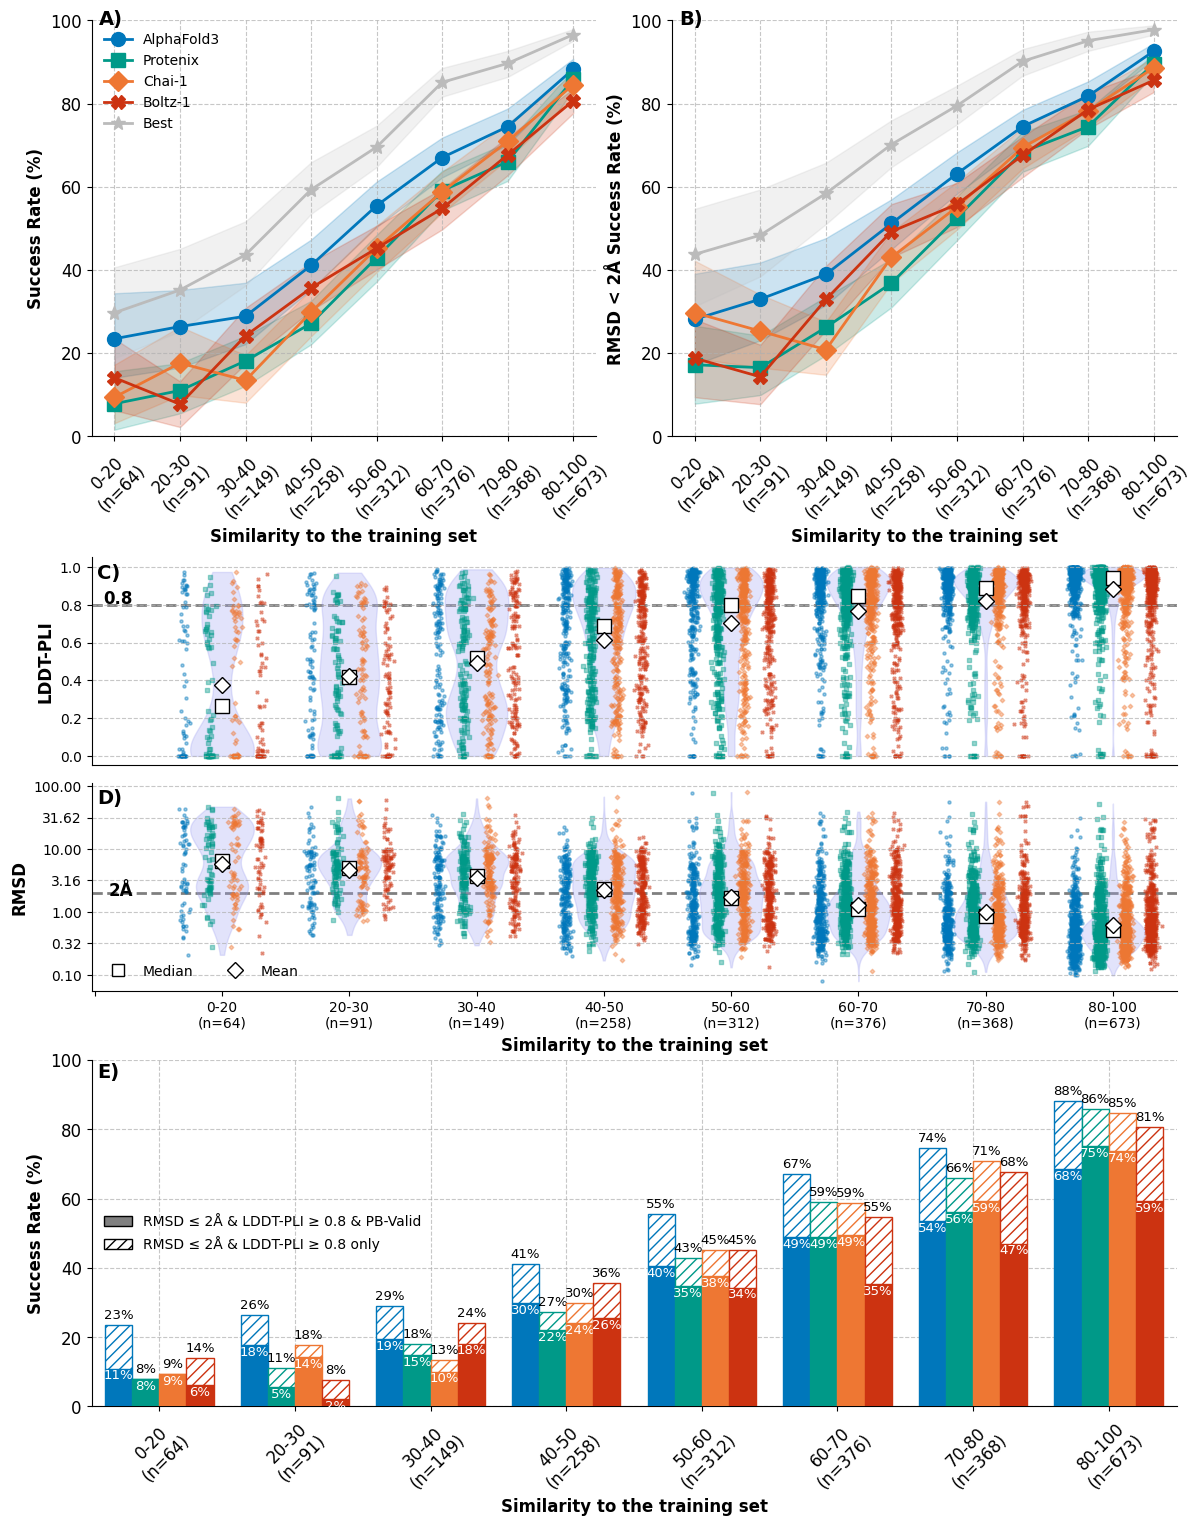

In [11]:
plotting.make_main_figure(
    common_subset_dfs_all["top"],
    figures_dir / "fig_1.png",
)

### PoseBusters results

In [12]:
bust_columns = [
    "sanitization",
    "inchi_convertible",
    "all_atoms_connected",
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "non-aromatic_ring_non-flatness",
    "double_bond_flatness",
    "internal_energy",
    "protein-ligand_maximum_distance",
    "minimum_distance_to_protein",
    "volume_overlap_with_protein",
]

all_total = defaultdict(int)
all_fail = defaultdict(int)
for method in plotting.COMMON_SUBSET_METHODS:
    for col in bust_columns:
        all_fail[col] += bust_dfs[method][col].value_counts().get(False, 0)
        all_total[col] += bust_dfs[method][col].shape[0]

print("Check\t% Failed")
for col in bust_columns:
    print(f"{col}\t{100 * all_fail[col] / all_total[col]:.2f}")

Check	% Failed
sanitization	0.00
inchi_convertible	0.00
all_atoms_connected	0.00
bond_lengths	0.21
bond_angles	0.02
internal_steric_clash	0.56
aromatic_ring_flatness	0.56
non-aromatic_ring_non-flatness	3.28
double_bond_flatness	0.31
internal_energy	0.63
protein-ligand_maximum_distance	0.00
minimum_distance_to_protein	22.64
volume_overlap_with_protein	1.28


In [13]:
bins = [0, 50, 100]
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    subset = common_subset_dfs_all["top"][
        (common_subset_dfs_all["top"][plotting.SIMILARITY_METRIC] >= lower)
        & (common_subset_dfs_all["top"][plotting.SIMILARITY_METRIC] < upper)
        & (common_subset_dfs_all["top"]["ligand_is_proper"])
        & (common_subset_dfs_all["top"]["sucos_shape"].notna())
    ]
    vals = []
    for m in plotting.COMMON_SUBSET_METHODS:
        subset_m = subset[
            (subset[f"lddt_pli_{m}"] >= plotting.LDDT_PLI_THRESHOLD)
            & (subset[f"rmsd_{m}"] <= plotting.RMSD_THRESHOLD)
        ]
        vals.append(
            subset_m[subset_m[f"pb_success_{m}"] == 1].shape[0] / subset_m.shape[0]
        )
    mean_val = np.mean(vals)
    std_val = np.std(vals)
    print(f"{lower}-{upper}: {100 * mean_val:.2f} $\pm$ {100 * std_val:.2f}")

0-50: 74.38 $\pm$ 5.71
50-100: 79.19 $\pm$ 6.25


## Model and data choices lead to minimal performance improvement

### Supplementary Figure S1

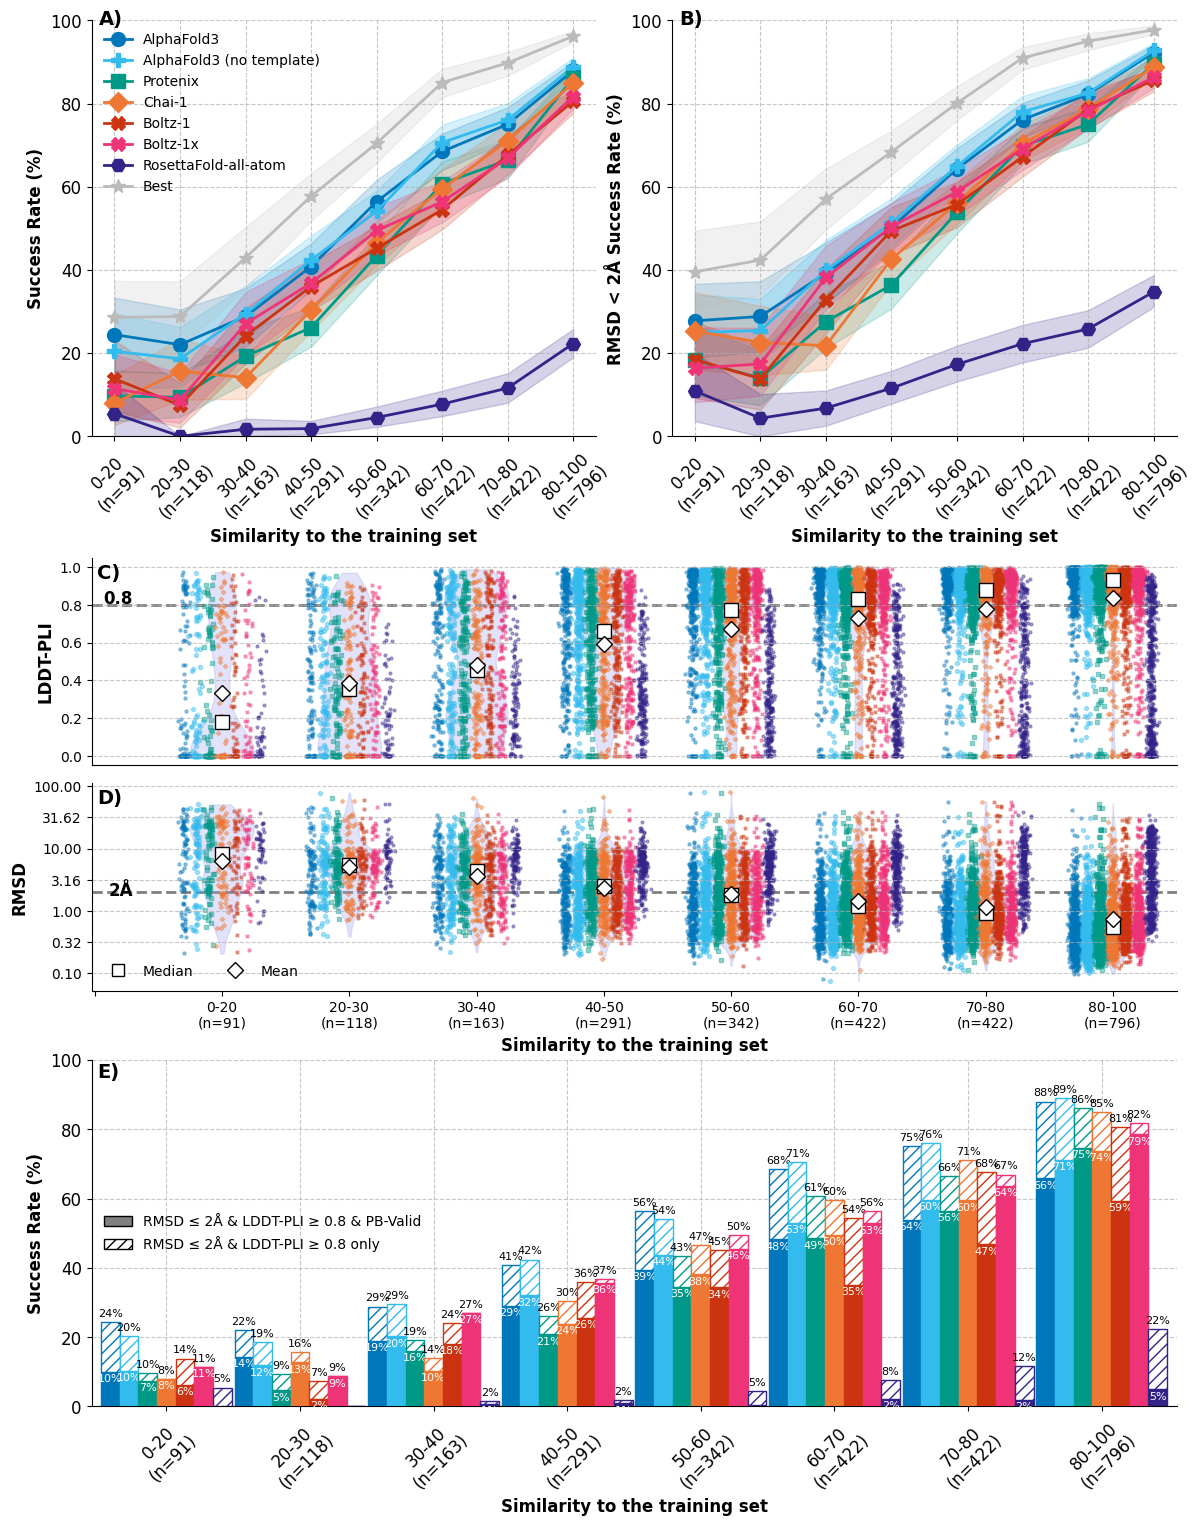

In [43]:
plotting.make_main_figure(
    dfs["top"],
    figures_dir / "supp_fig_all_methods.png",
    pb_fontsize=8,
    methods=[m for m in plotting.METHODS if m != "boltz2"],
    bar_width=0.14,
    scatter_spacing=0.1,
)

### Table 1

In [14]:
for method in plotting.METHODS:
    print(method)
    df = dfs["top"][dfs["top"][f"rmsd_{method}"].notna()]
    print("No. PDB IDs:", len(set(df["system_id"].map(lambda x: x[:4]))))
    print("No. systems:", df["system_id"].nunique())
    print(
        "No. ligands (including ions and artifacts):",
        df["system_id"]
        .drop_duplicates()
        .map(lambda x: len(x.split("__")[-1].split("_")))
        .sum(),
    )
    print(
        "No. proper ligands:",
        annotated_df[annotated_df["system_id"].isin(df["system_id"])][
            "ligand_is_proper"
        ].sum(),
    )
    plindex_proper = annotated_df[
        annotated_df["ligand_is_proper"]
        & annotated_df["system_id"].isin(df["system_id"])
    ].reset_index(drop=True)
    print(
        "No. multi-ligand systems:",
        len(
            plindex_proper[plindex_proper.duplicated(subset=["system_id"], keep=False)][
                "system_id"
            ].unique()
        ),
    )
    print(
        "No. multi-protein systems:",
        df["system_id"]
        .drop_duplicates()
        .map(lambda x: len(x.split("__")[2].split("_")) > 1)
        .sum(),
    )
    print()

af3
No. PDB IDs: 2415
No. systems: 2429
No. ligands (including ions and artifacts): 3906
No. proper ligands: 2710
No. multi-ligand systems: 296
No. multi-protein systems: 739

af3_no_template
No. PDB IDs: 2417
No. systems: 2431
No. ligands (including ions and artifacts): 3907
No. proper ligands: 2711
No. multi-ligand systems: 295
No. multi-protein systems: 739

protenix
No. PDB IDs: 2329
No. systems: 2343
No. ligands (including ions and artifacts): 3772
No. proper ligands: 2609
No. multi-ligand systems: 281
No. multi-protein systems: 703

chai
No. PDB IDs: 2300
No. systems: 2313
No. ligands (including ions and artifacts): 3730
No. proper ligands: 2572
No. multi-ligand systems: 275
No. multi-protein systems: 687

boltz
No. PDB IDs: 2145
No. systems: 2159
No. ligands (including ions and artifacts): 3418
No. proper ligands: 2400
No. multi-ligand systems: 256
No. multi-protein systems: 627

boltz1x
No. PDB IDs: 2097
No. systems: 2111
No. ligands (including ions and artifacts): 3366
No. pro

In [16]:
boltz_training_cutoff = pd.to_datetime("2023-06-01")
similarity_df_boltz2 = (
    all_similarity_scores[
        all_similarity_scores["target_release_date"] < boltz_training_cutoff
    ]
    .sort_values(by="sucos_shape_pocket_qcov", ascending=False)
    .groupby("group_key")
    .head(1)
    .reset_index(drop=True)
)
usable_systems = set(
    annotated_df[annotated_df["release_date"] > boltz_training_cutoff]["system_id"]
)
similarity_2023 = dict(
    zip(
        similarity_df_boltz2["group_key"],
        similarity_df_boltz2["sucos_shape_pocket_qcov"],
    )
)
annotated_df["sucos_shape_pocket_qcov_2023"] = annotated_df["group_key"].map(
    similarity_2023
)
len(usable_systems)


1028

In [17]:
print("Total (Post-2023)")
df = annotated_df[annotated_df["system_id"].isin(usable_systems)]
print("No. PDB IDs:", len(set(df["system_id"].map(lambda x: x[:4]))))
print("No. systems:", df["system_id"].nunique())
print(
    "No. ligands (including ions and artifacts):",
    df["system_id"]
    .drop_duplicates()
    .map(lambda x: len(x.split("__")[-1].split("_")))
    .sum(),
)
print(
    "No. proper ligands:",
    annotated_df[annotated_df["system_id"].isin(df["system_id"])][
        "ligand_is_proper"
    ].sum(),
)
plindex_proper = annotated_df[
    annotated_df["ligand_is_proper"] & annotated_df["system_id"].isin(df["system_id"])
].reset_index(drop=True)
print(
    "No. multi-ligand systems:",
    len(
        plindex_proper[plindex_proper.duplicated(subset=["system_id"], keep=False)][
            "system_id"
        ].unique()
    ),
)
print(
    "No. multi-protein systems:",
    df["system_id"]
    .drop_duplicates()
    .map(lambda x: len(x.split("__")[2].split("_")) > 1)
    .sum(),
)
print()

Total (Post-2023)
No. PDB IDs: 1025
No. systems: 1028
No. ligands (including ions and artifacts): 1685
No. proper ligands: 1187
No. multi-ligand systems: 142
No. multi-protein systems: 415



In [18]:
print("Boltz-1")
df = dfs["top"][
    dfs["top"]["system_id"].isin(usable_systems) & (dfs["top"]["rmsd_boltz"].notna())
]
print("No. PDB IDs:", len(set(df["system_id"].map(lambda x: x[:4]))))
print("No. systems:", df["system_id"].nunique())
print(
    "No. ligands (including ions and artifacts):",
    df["system_id"]
    .drop_duplicates()
    .map(lambda x: len(x.split("__")[-1].split("_")))
    .sum(),
)
print(
    "No. proper ligands:",
    annotated_df[annotated_df["system_id"].isin(df["system_id"])][
        "ligand_is_proper"
    ].sum(),
)
plindex_proper = annotated_df[
    annotated_df["ligand_is_proper"] & annotated_df["system_id"].isin(df["system_id"])
].reset_index(drop=True)
print(
    "No. multi-ligand systems:",
    len(
        plindex_proper[plindex_proper.duplicated(subset=["system_id"], keep=False)][
            "system_id"
        ].unique()
    ),
)
print(
    "No. multi-protein systems:",
    df["system_id"]
    .drop_duplicates()
    .map(lambda x: len(x.split("__")[2].split("_")) > 1)
    .sum(),
)
print()

Boltz-1
No. PDB IDs: 841
No. systems: 844
No. ligands (including ions and artifacts): 1322
No. proper ligands: 933
No. multi-ligand systems: 87
No. multi-protein systems: 347



### Figure 2

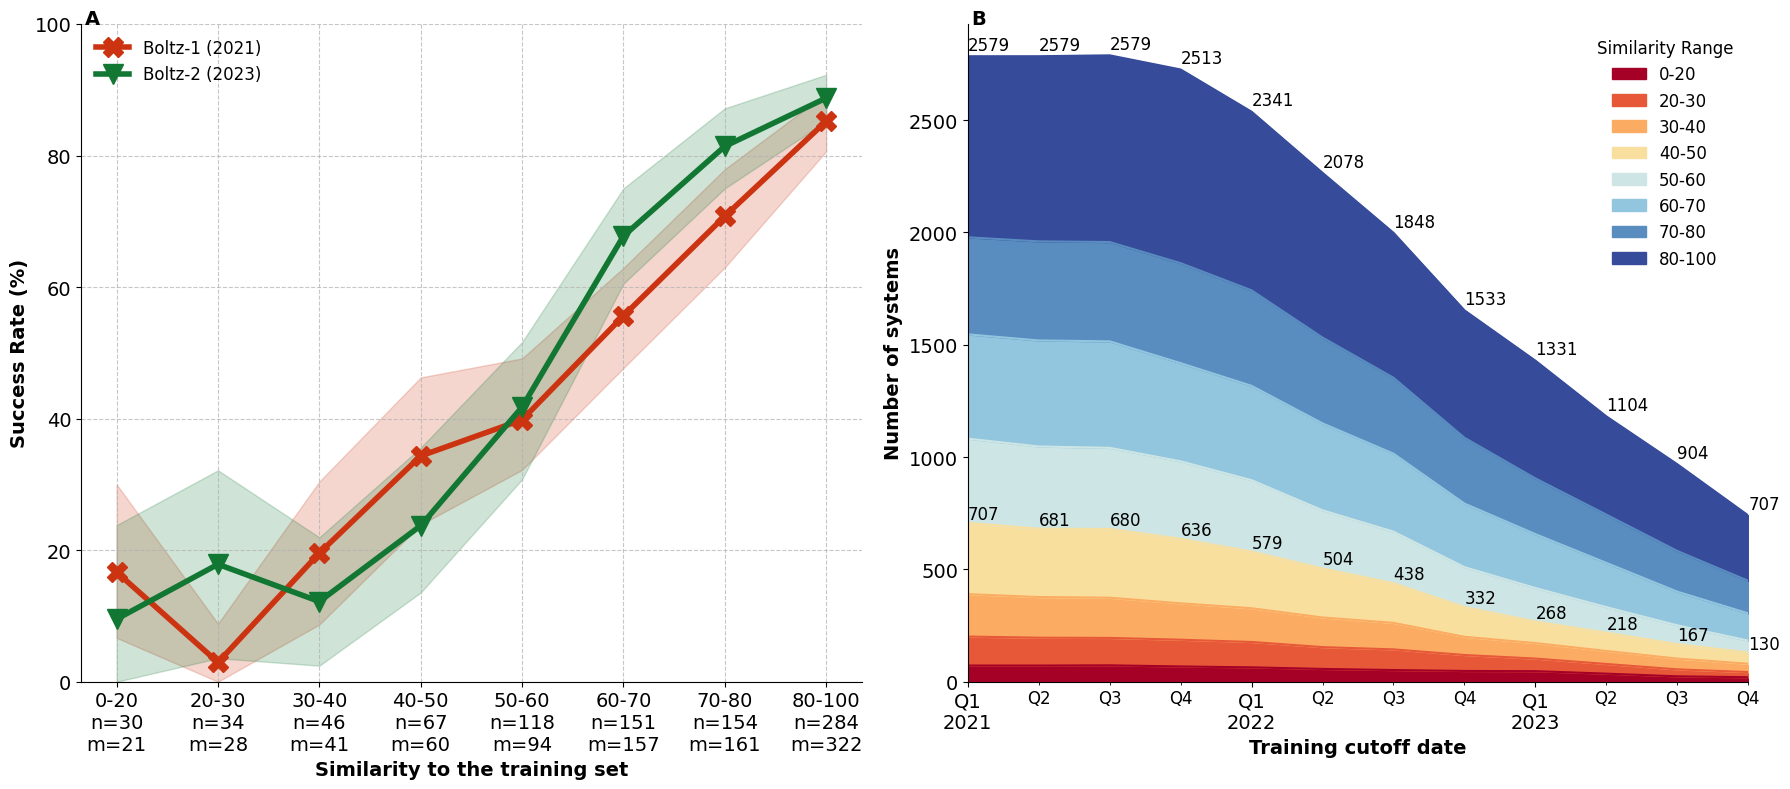

In [19]:
plotting.make_figure_boltz2_time(
    common_subset_dfs_all["top"],
    annotated_df,
    all_similarity_scores,
    figures_dir / "fig_boltz2_time.png",
)

## Impact of ligand and complex prevalence

### Figure 3

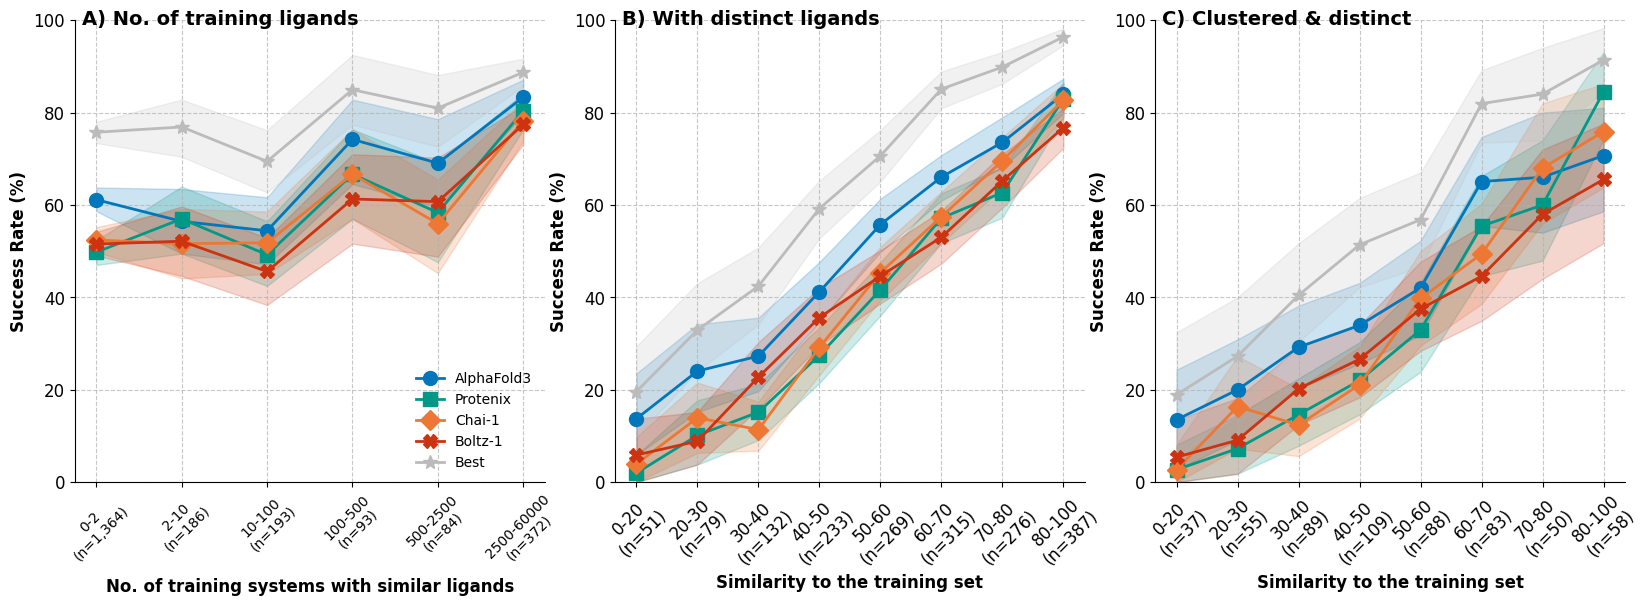

In [20]:
plotting.make_figure_prevalent_distinct_clustered(
    common_subset_dfs_all["top"],
    cluster_dfs_all["top"],
    figures_dir / "fig_prevalent_distinct_clustered.png",
)

### Supplementary Figure S2

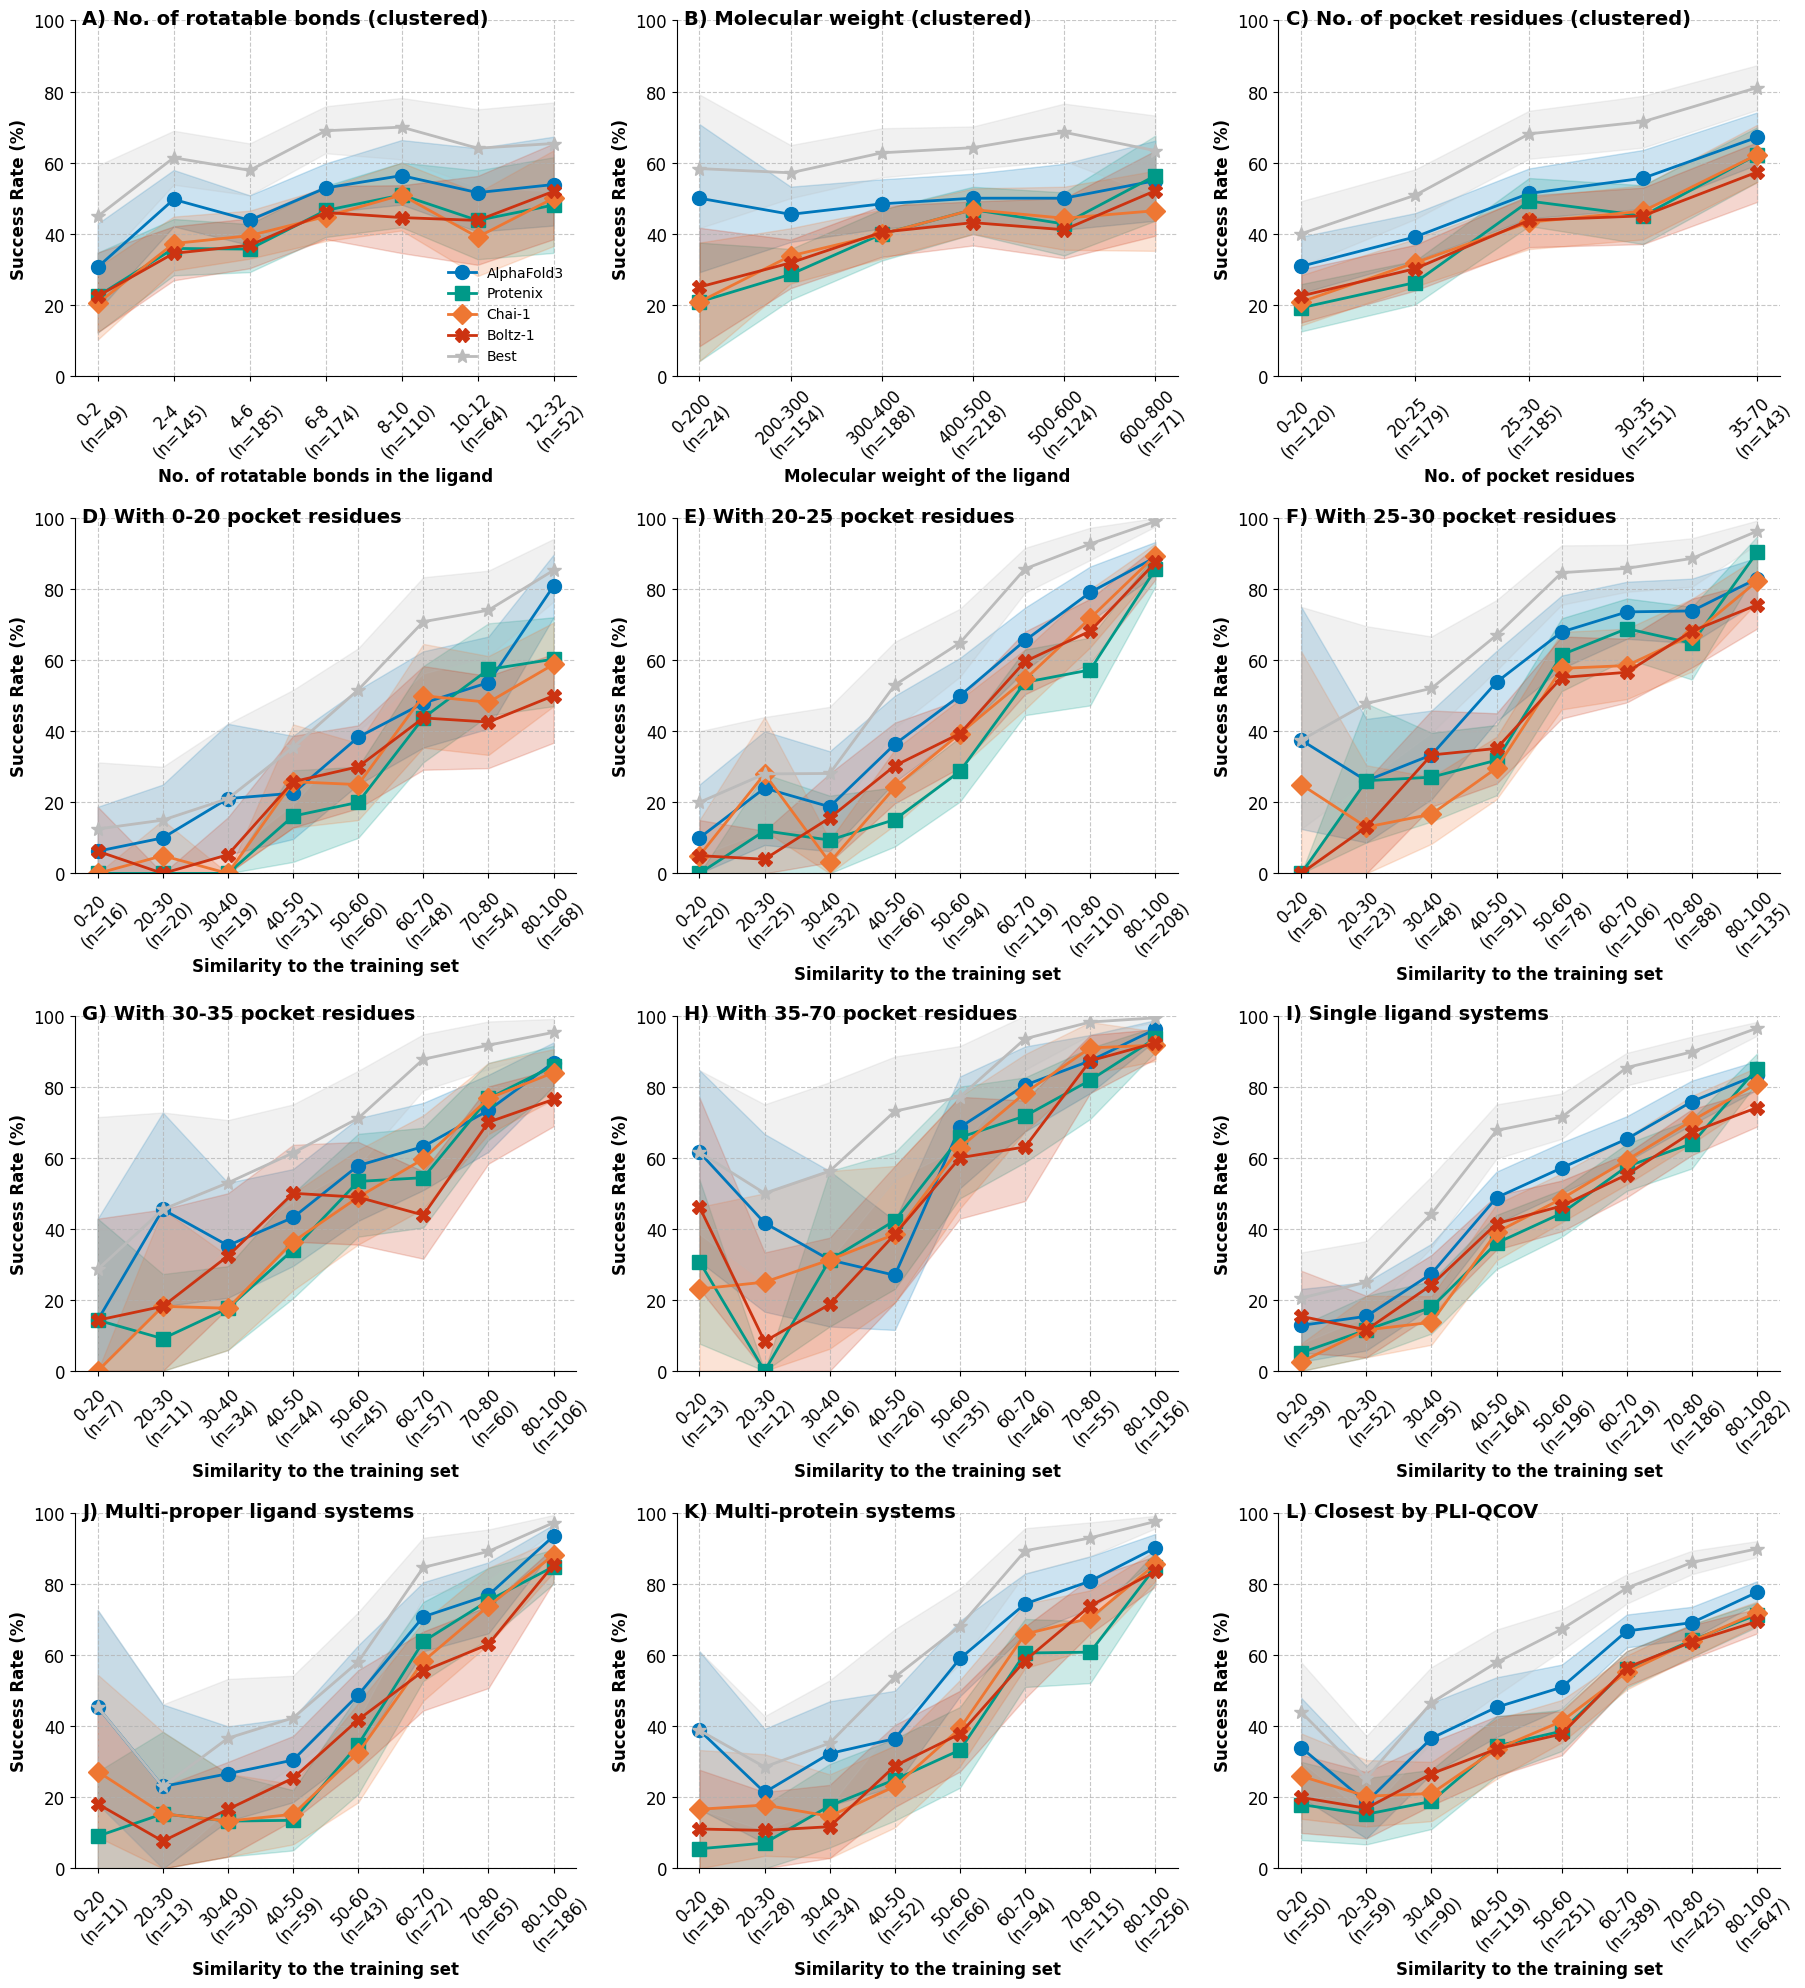

In [21]:
plotting.make_figure_stratifications(
    common_subset_dfs_all["top"],
    cluster_dfs_all["top"],
    figures_dir / "supp_fig_stratifications.png",
)

### Supplementary Table S1

In [26]:
plotting.cluster_representatives_table(annotated_df)

Cluster size & PDB ID & Keywords & Similarity bins \\
171 & 7EN9 & VIRAL PROTEIN & 80-100 (79), 70-80 (46), 60-70 (25), 50-60 (15), 40-50 (6) \\
\midrule

136 & 8OKU & SIGNALING PROTEIN & 60-70 (38), 70-80 (37), 80-100 (28), 50-60 (19), 40-50 (11), 30-40 (3) \\
\midrule

100 & 5SH0 & HYDROLASE/HYDROLASE inhibitor & 50-60 (33), 40-50 (26), 30-40 (16), 60-70 (13), 80-100 (5), 20-30 (4), 70-80 (3) \\
\midrule

92 & 8HUU & VIRAL PROTEIN & 80-100 (43), 60-70 (20), 70-80 (20), 40-50 (5), 50-60 (4) \\
\midrule

73 & 7S3Z & OXIDOREDUCTASE/Inhibitor & 80-100 (51), 70-80 (16), 60-70 (5), 50-60 (1) \\
\midrule

43 & 8JOO & OXIDOREDUCTASE & 80-100 (23), 60-70 (5), 70-80 (5), 30-40 (4), 40-50 (3), 50-60 (3) \\
\midrule

35 & 7G00 & LIPID BINDING PROTEIN & 60-70 (13), 50-60 (10), 40-50 (6), 70-80 (3), 80-100 (2), 30-40 (1) \\
\midrule

28 & 7S1S & TRANSFERASE/INHIBITOR & 80-100 (12), 40-50 (6), 50-60 (3), 60-70 (3), 30-40 (2), 70-80 (2) \\
\midrule

28 & 7UBO & TRANSCRIPTION/INHIBITOR & 70-80 (7), 8

### Supplementary Figure S2

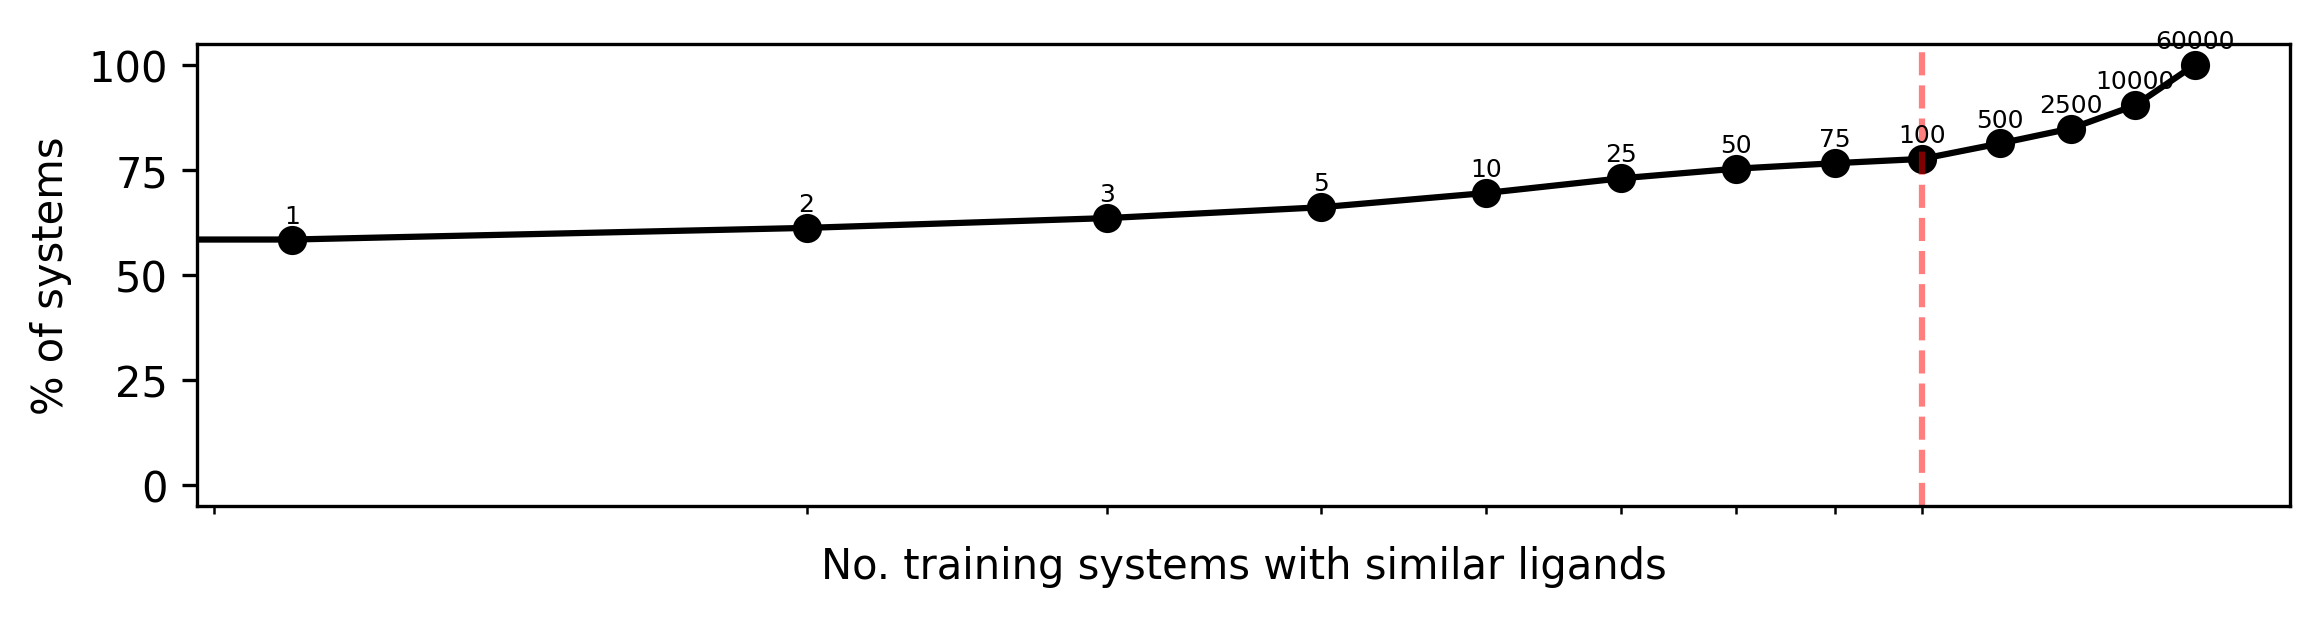

In [27]:
plotting.make_figure_ligand_prevalence(
    common_subset_dfs_all["top"][
        common_subset_dfs_all["top"]["ligand_is_proper"]
        & (common_subset_dfs_all["top"]["sucos_shape"].notna())
    ],
    figures_dir / "fig_ligand_prevalence.png",
)

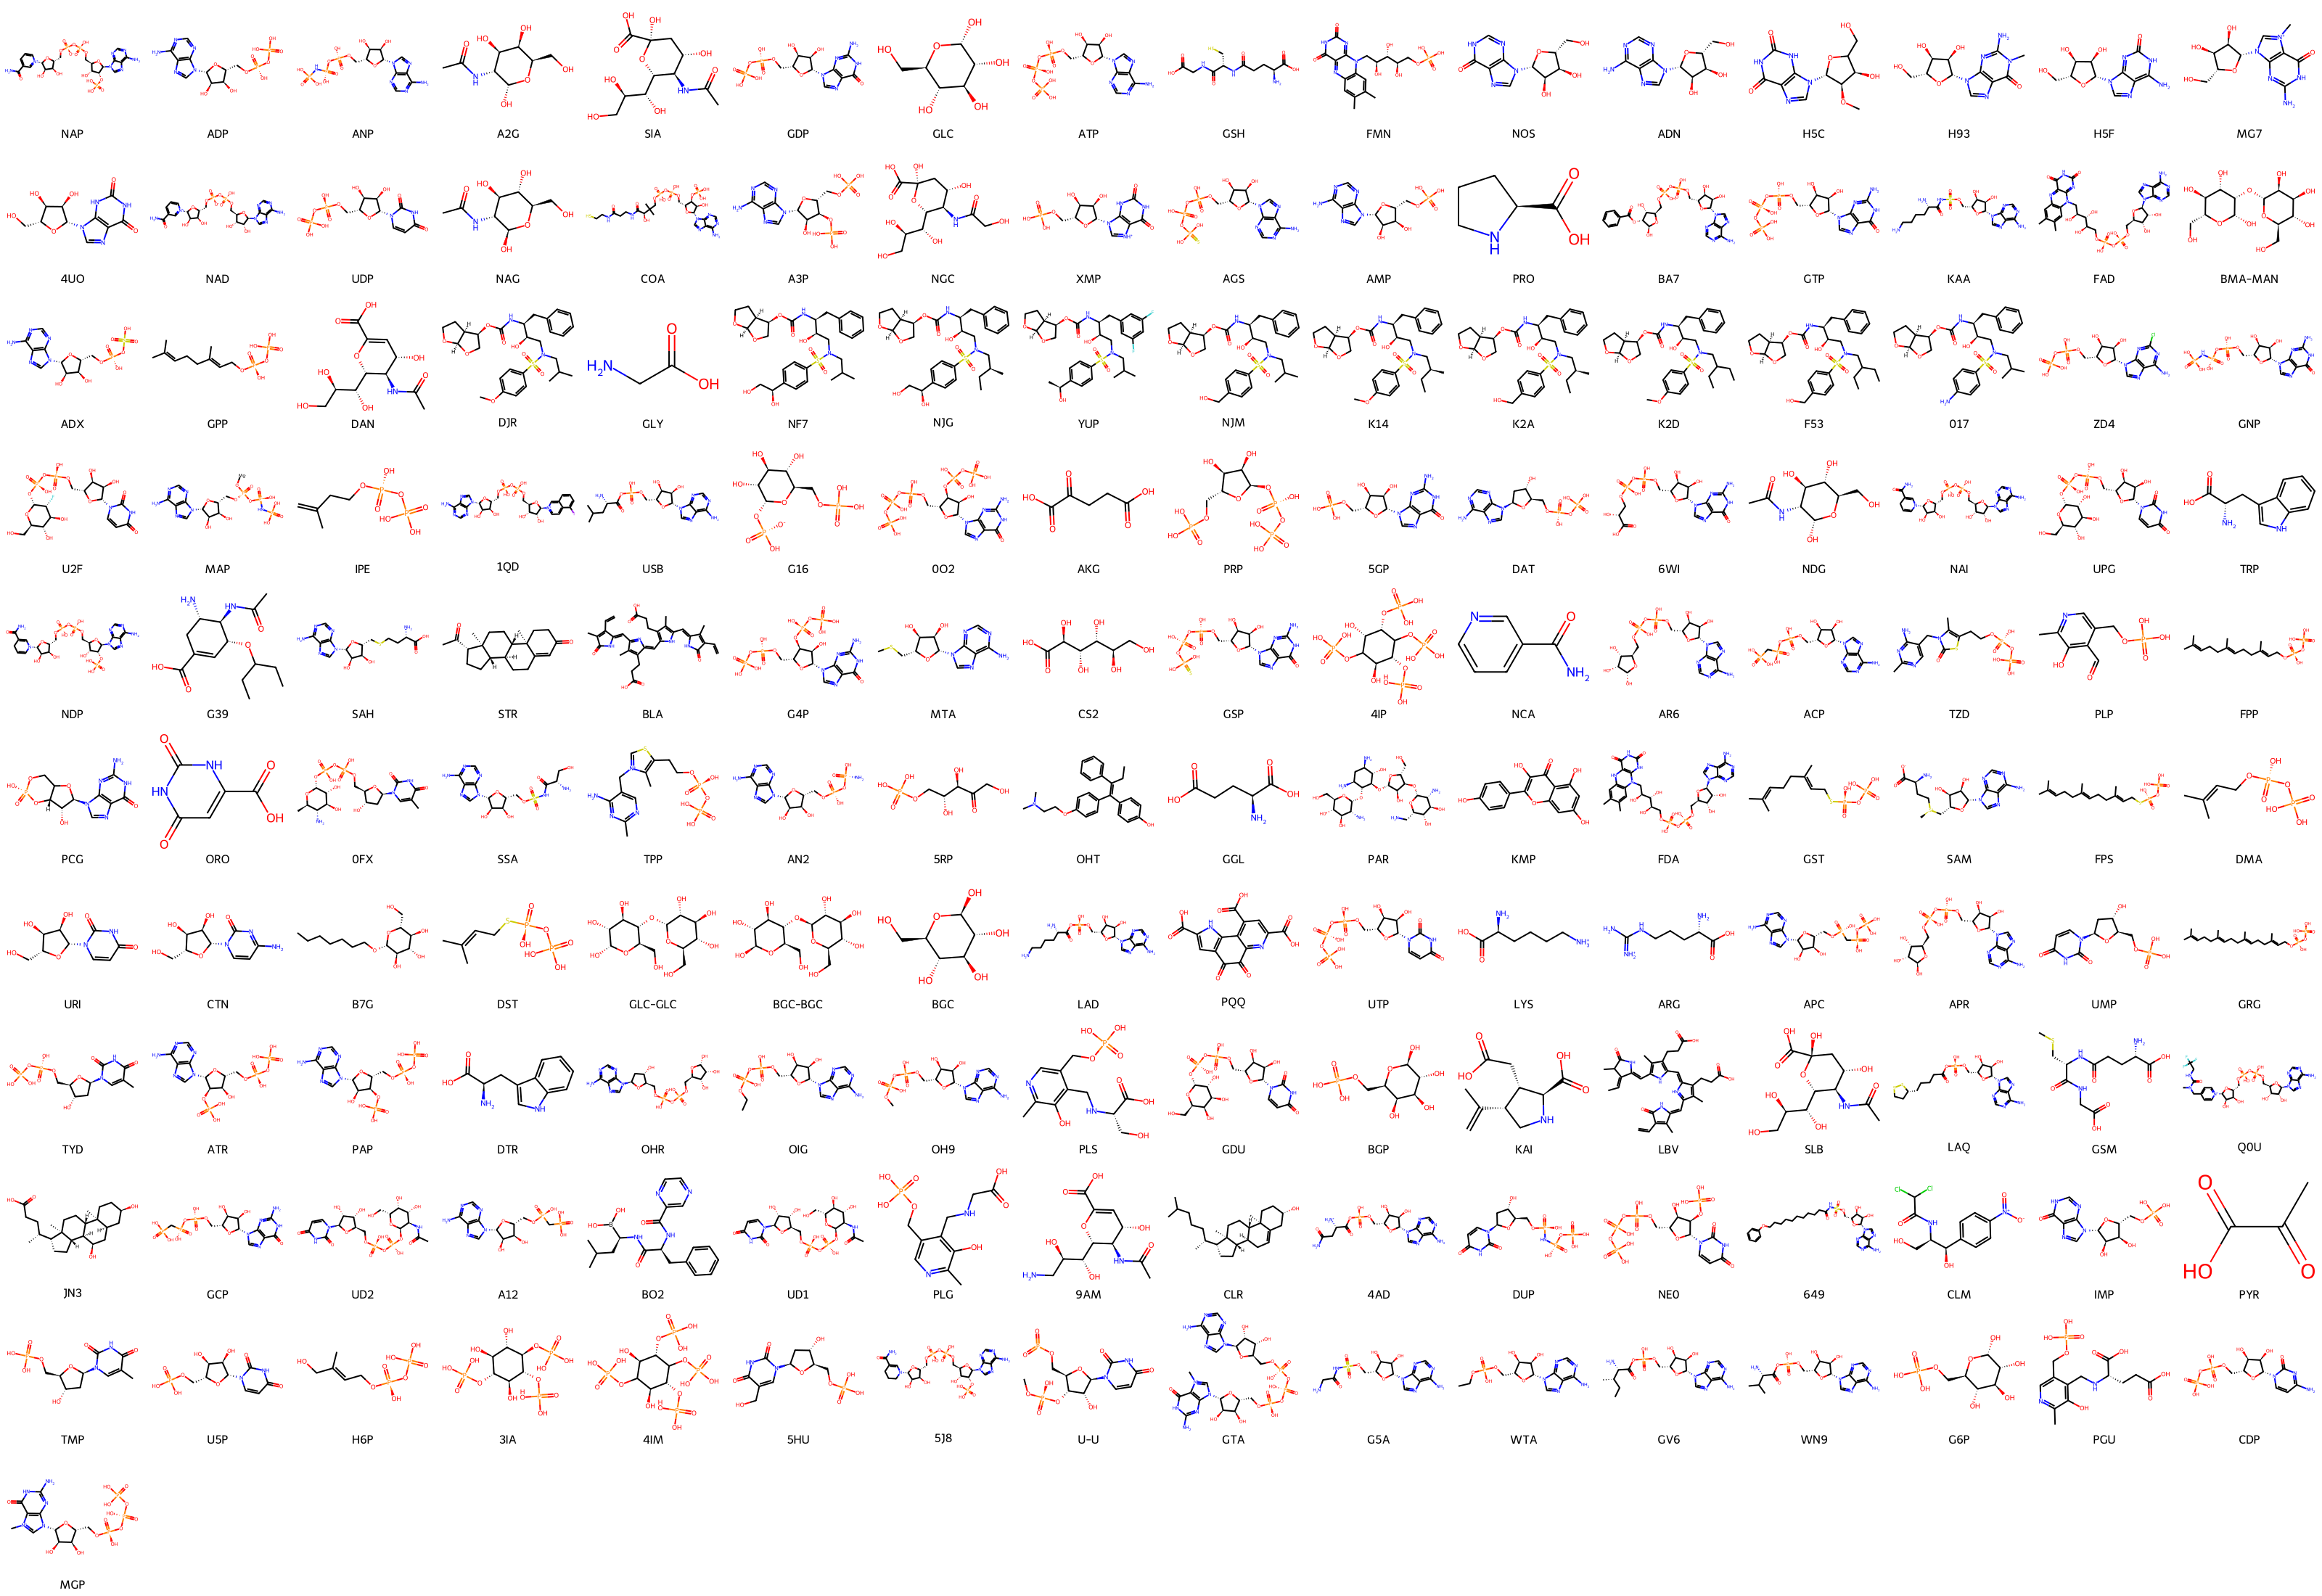

In [28]:
plotting.make_figure_prevalent_ligands(
    common_subset_dfs_all["top"][
        common_subset_dfs_all["top"]["ligand_is_proper"]
        & (common_subset_dfs_all["top"]["sucos_shape"].notna())
    ],
    figures_dir / "fig_prevalent_ligands.png",
)

## Ligand and protein similarity metrics for detecting data leakage

### Figure 4

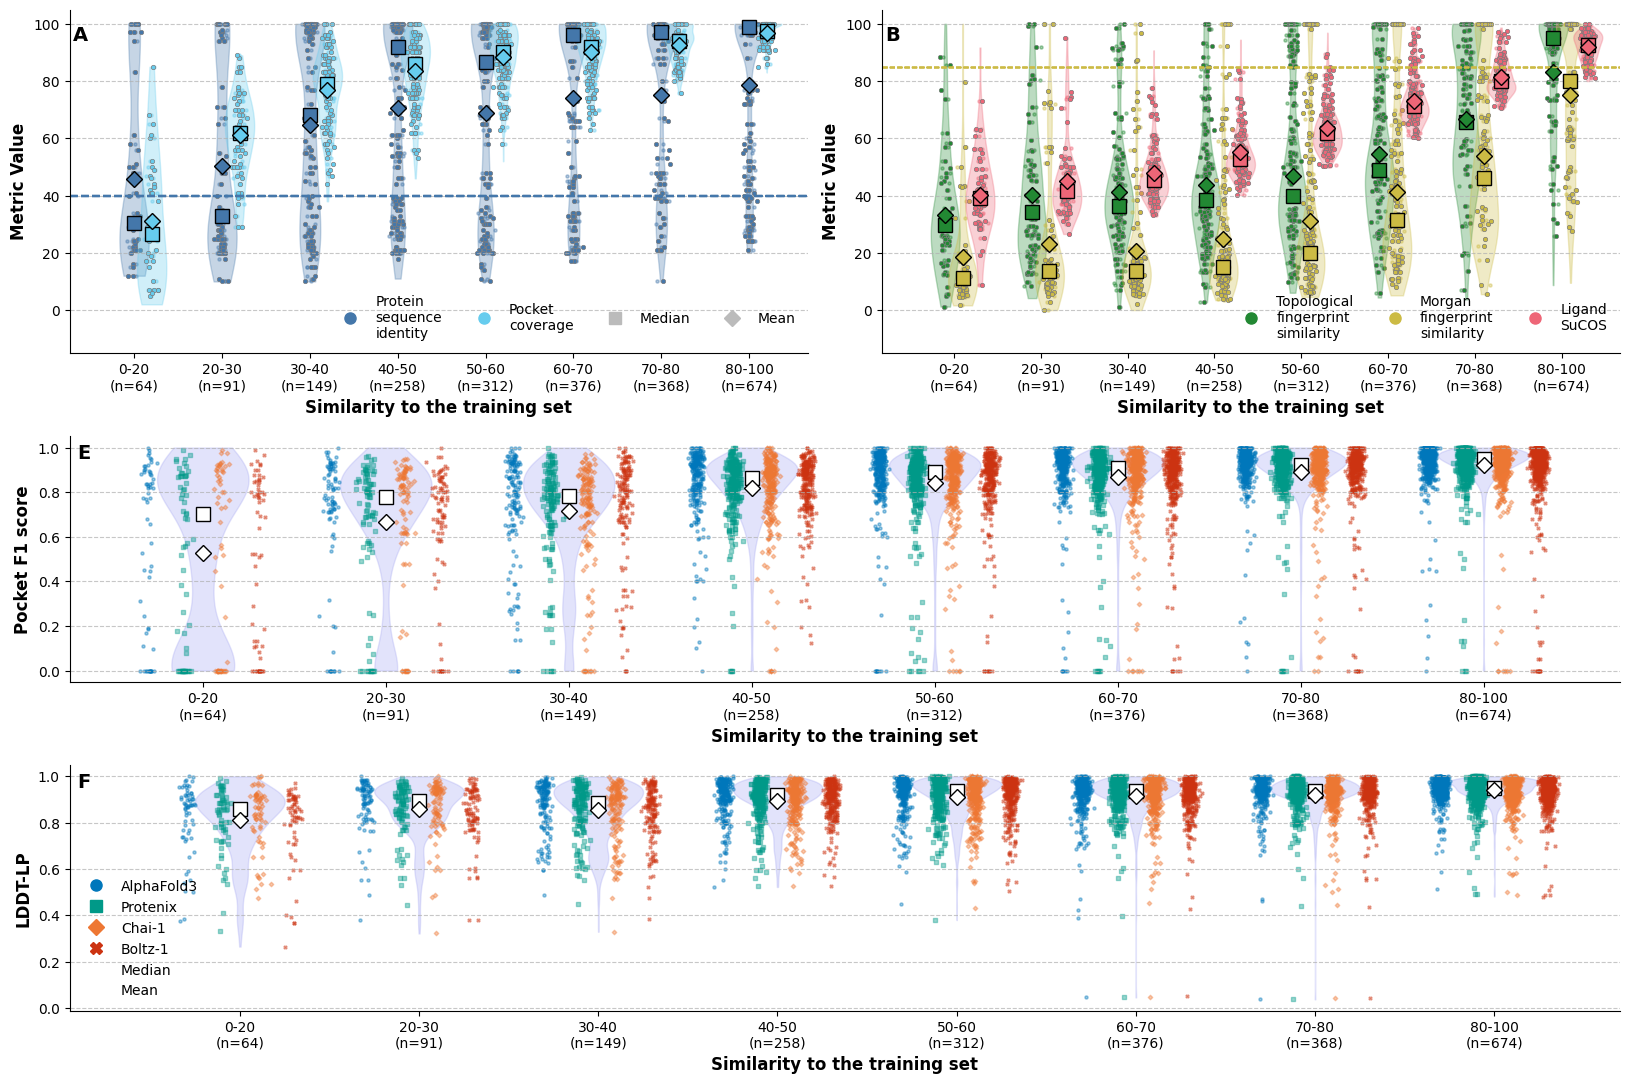

In [22]:
plotting.other_metrics(
    common_subset_dfs_all["top"],
    cluster_dfs_all["top"],
    figures_dir / "fig_other_metrics.png",
)

## Room for improvement in sampling and ranking of ligand poses

### Figure 6

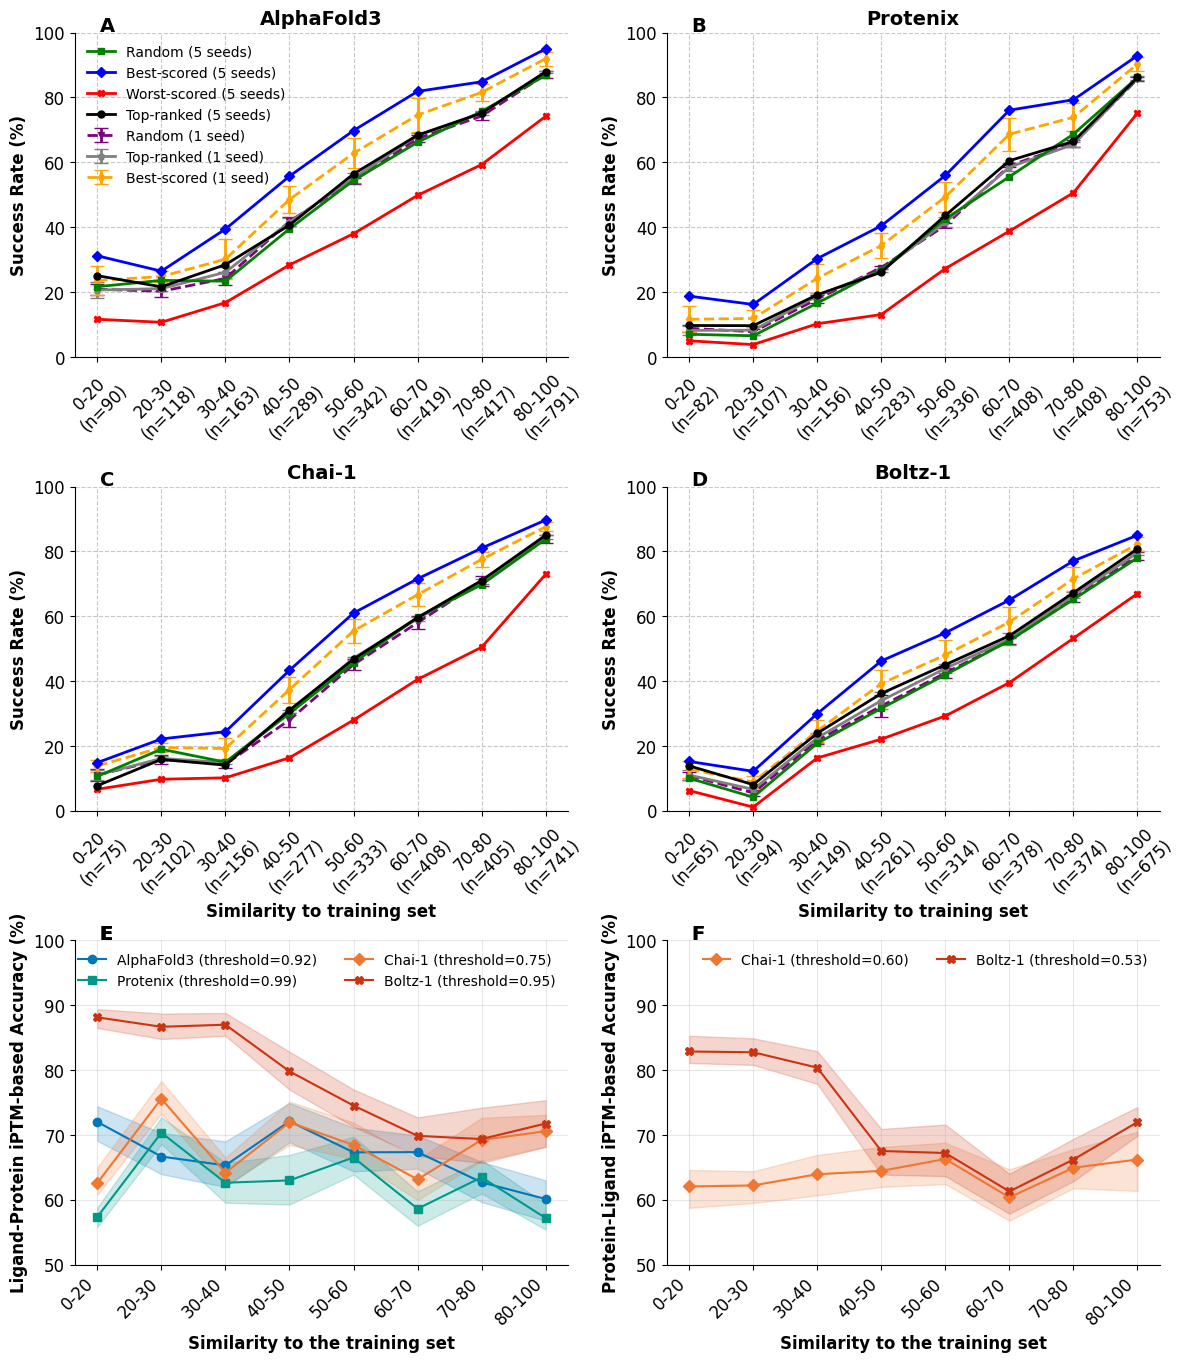

In [23]:
plotting.confidence_plot(
    dfs,
    full_datasets,
    annotated_df,
    figures_dir / "fig_confidence.png",
    methods=plotting.COMMON_SUBSET_METHODS,
)

## Methods

### Figure 7

Percentage of systems with RMSD < 2Å and LDDT-PLI < 0.8: 8.40
Percentage of systems with RMSD > 2Å and LDDT-PLI > 0.8: 1.59


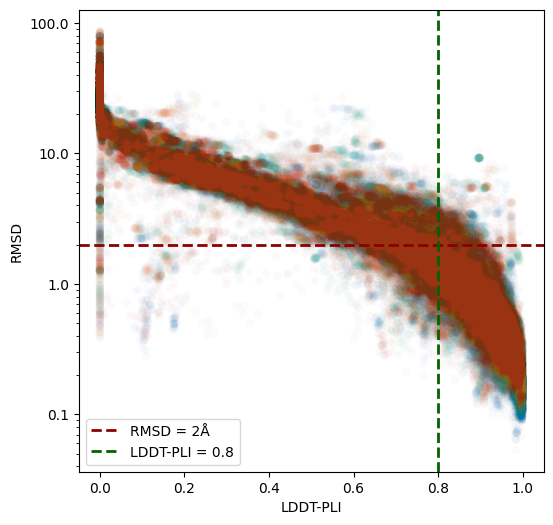

In [24]:
plotting.rmsd_vs_lddt_pli(full_datasets, figures_dir / "fig_rmsd_lddt_pli.png")

### Supplementary Figure S4

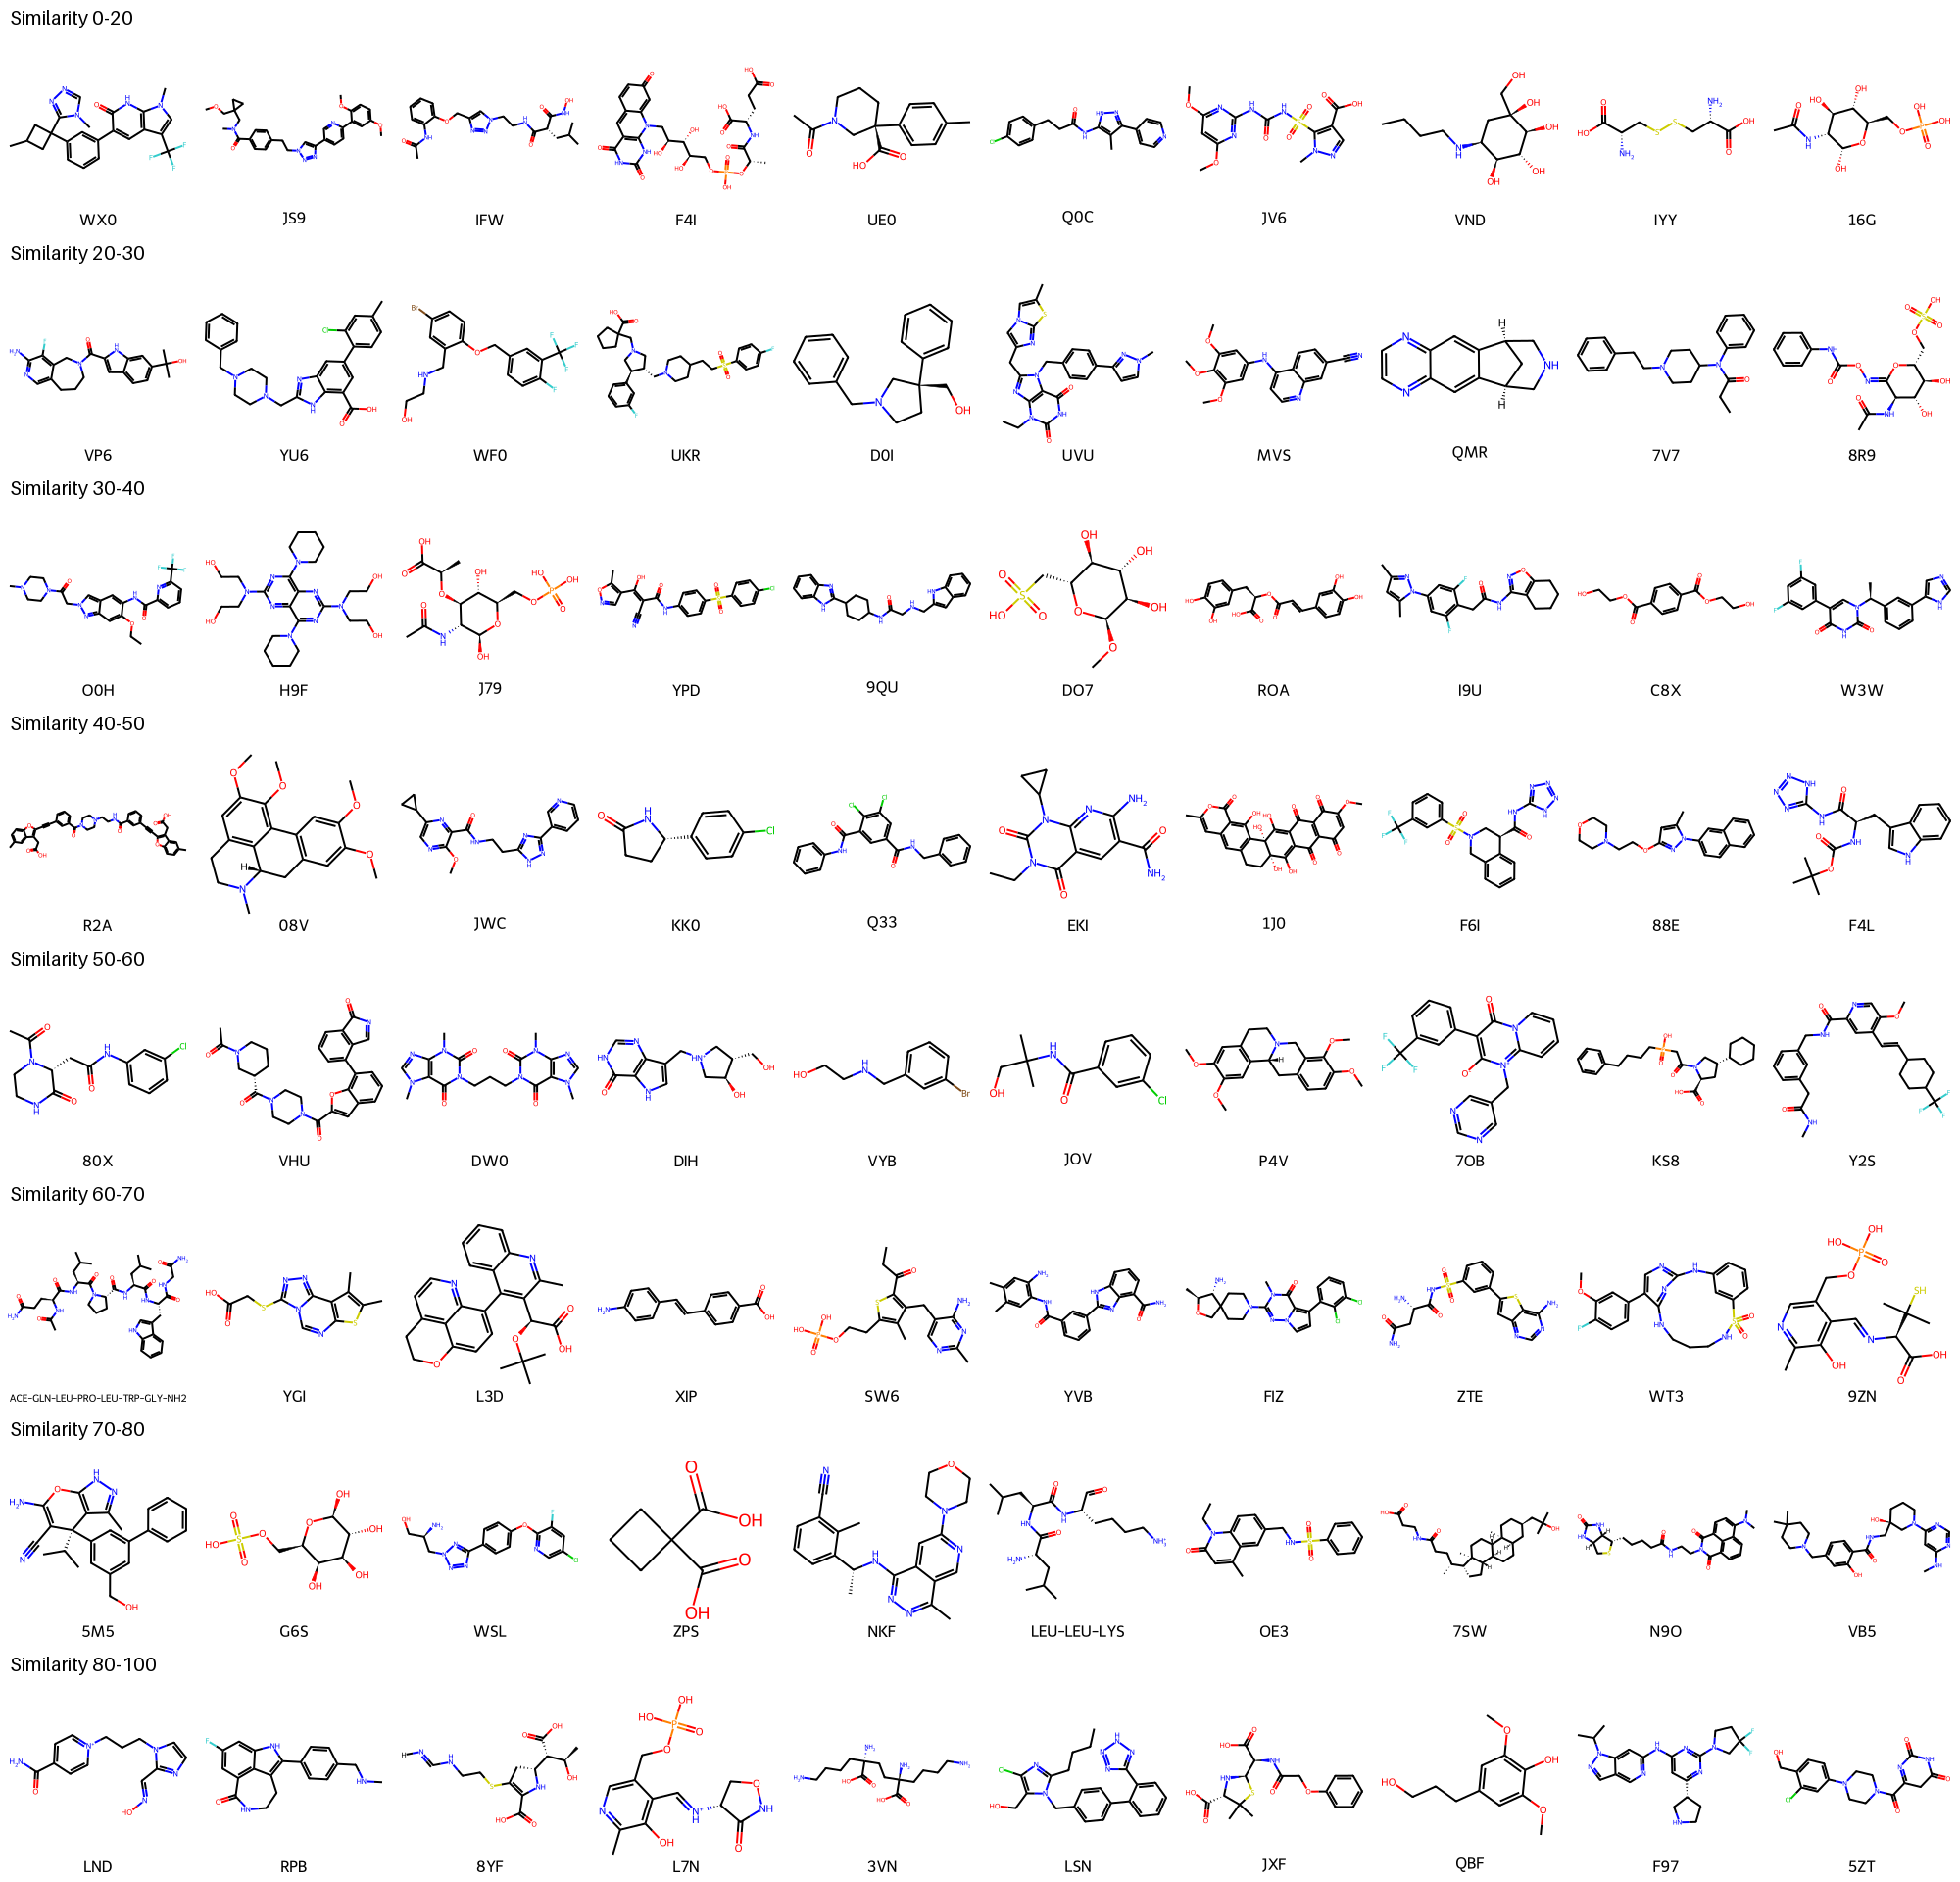

In [25]:
plotting.example_molecules_per_bin(
    cluster_dfs_all["top"], figures_dir / "fig_example_molecules_per_bin.png"
)